In [3]:
!pip install pyaurn

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output

In [5]:
metadata = pyaurn.importMeta().set_index("site_id")

In [6]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "location_type", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [7]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["date"] = data["date"].apply(lambda e: e.timestamp())
    if "PM2.5" in data.columns:
      data = data[["date", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id")
      return data
  except KeyError:
    return

In [8]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2020, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [9]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

,date,PM2.5,site_id,latitude,longitude
0,1.577837e+09,13.0,YK11,53.951889,-1.075861
1,1.577840e+09,13.0,YK11,53.951889,-1.075861
2,1.577844e+09,13.0,YK11,53.951889,-1.075861
3,1.577848e+09,11.0,YK11,53.951889,-1.075861
4,1.577851e+09,9.0,YK11,53.951889,-1.075861
...,...,...,...,...,...
16656,1.640977e+09,23.8,YK11,53.951889,-1.075861
16657,1.640981e+09,8.8,YK11,53.951889,-1.075861
16658,1.640984e+09,14.8,YK11,53.951889,-1.075861
16659,1.640988e+09,11.8,YK11,53.951889,-1.075861


,date,PM2.5,site_id,latitude,longitude
0,1.577837e+09,13.000,YK11,53.951889,-1.075861
1,1.577840e+09,13.000,YK11,53.951889,-1.075861
2,1.577844e+09,13.000,YK11,53.951889,-1.075861
3,1.577848e+09,11.000,YK11,53.951889,-1.075861
4,1.577851e+09,9.000,YK11,53.951889,-1.075861
...,...,...,...,...,...
1322701,1.640977e+09,25.401,ABD9,57.157400,-2.094770
1322702,1.640981e+09,27.241,ABD9,57.157400,-2.094770
1322703,1.640984e+09,42.429,ABD9,57.157400,-2.094770
1322704,1.640988e+09,29.599,ABD9,57.157400,-2.094770


In [29]:
def split_data_into_named_datasets(data_to_split):
    result = {}
    split_data = data_to_split.groupby(by=data_to_split.site_id)
    for name, group_data in split_data:
        sets = {}
        full_dataset = tf.keras.utils.timeseries_dataset_from_array(data=group_data["date"], targets=group_data["PM2.5"], sequence_length=64)
        DATASET_SIZE = len(full_dataset)

        train_size = int(0.7 * DATASET_SIZE)
        val_size = int(0.15 * DATASET_SIZE)
        test_size = int(0.15 * DATASET_SIZE)

        sets["train"] = full_dataset.take(train_size)
        sets["val"] = full_dataset.skip(train_size).take(val_size)
        sets["test"] = full_dataset.skip(train_size).skip(test_size)
        result[name] = sets
    return result

In [32]:
datasets = split_data_into_named_datasets(concatenated_data)

c:\Users\ltrowbridge\.conda\envs\tf_gpu\lib\site-packages\keras\preprocessing\timeseries.py:226: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dataset = tf.data.Dataset.from_tensors(array[start_index : end_index])
c:\Users\ltrowbridge\.conda\envs\tf_gpu\lib\site-packages\keras\preprocessing\timeseries.py:226: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dataset = tf.data.Dataset.from_tensors(array[start_index : end_index])
c:\Users\ltrowbridge\.conda\envs\tf_gpu\lib\site-package

In [57]:
def get_models(datasets):
    models = []
    for name, dataset in datasets.items():

        inputs = tf.keras.layers.Input((None, 1))
        lstm = tf.keras.layers.LSTM(64, return_sequences=True)(inputs)
        outputs = tf.keras.layers.Dense(1)(lstm)

        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
            loss="mean_absolute_error",
            metrics = ["mean_squared_error"]
        )

        print("Now training:", name)
        print(len(models) + 1, "/", len(datasets))
        model.fit(
            dataset["train"],
            epochs=10,
            callbacks=[
                #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                #                   patience=1, min_lr=0.001),
                #tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
            ],
            validation_data = dataset["val"]
        )

        print(model.evaluate(dataset["test"]))

        models.append(model)
    return models

In [58]:
models = get_models(datasets)

Now training: ABD
1 / 83
Epoch 1/10
81/81 [==============================] - 4s 24ms/step - loss: 3.3382 - mean_squared_error: 24.8067 - val_loss: 6.0813 - val_mean_squared_error: 43.7365
Epoch 2/10
81/81 [==============================] - 1s 15ms/step - loss: 3.5467 - mean_squared_error: 26.3686 - val_loss: 5.9238 - val_mean_squared_error: 41.7240
Epoch 3/10
81/81 [==============================] - 1s 15ms/step - loss: 3.5435 - mean_squared_error: 26.2986 - val_loss: 5.9607 - val_mean_squared_error: 42.1914
Epoch 4/10
81/81 [==============================] - 1s 16ms/step - loss: 3.5469 - mean_squared_error: 26.3139 - val_loss: 5.9377 - val_mean_squared_error: 41.8998
Epoch 5/10
81/81 [==============================] - 1s 16ms/step - loss: 3.5409 - mean_squared_error: 26.2733 - val_loss: 5.9289 - val_mean_squared_error: 41.7878
Epoch 6/10
81/81 [==============================] - 1s 15ms/step - loss: 3.5425 - mean_squared_error: 26.3023 - val_loss: 5.9487 - val_mean_squared_error: 42.03

<keras.engine.functional.Functional object at 0x00000194380505B0> {'train': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'val': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'test': <SkipDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>}
[[[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]

 [[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]

 [[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]

 ...

 [[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]

 [[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]

 [[ 9.35239 ]
  [10.38014 ]
  [10.537665]
  ...
  [10.562772]
  [10.562772]
  [10.562772]]]


array([ 9.35239 , 10.38014 , 10.537665, ..., 10.562772, 10.562772,
       10.562772], dtype=float32)

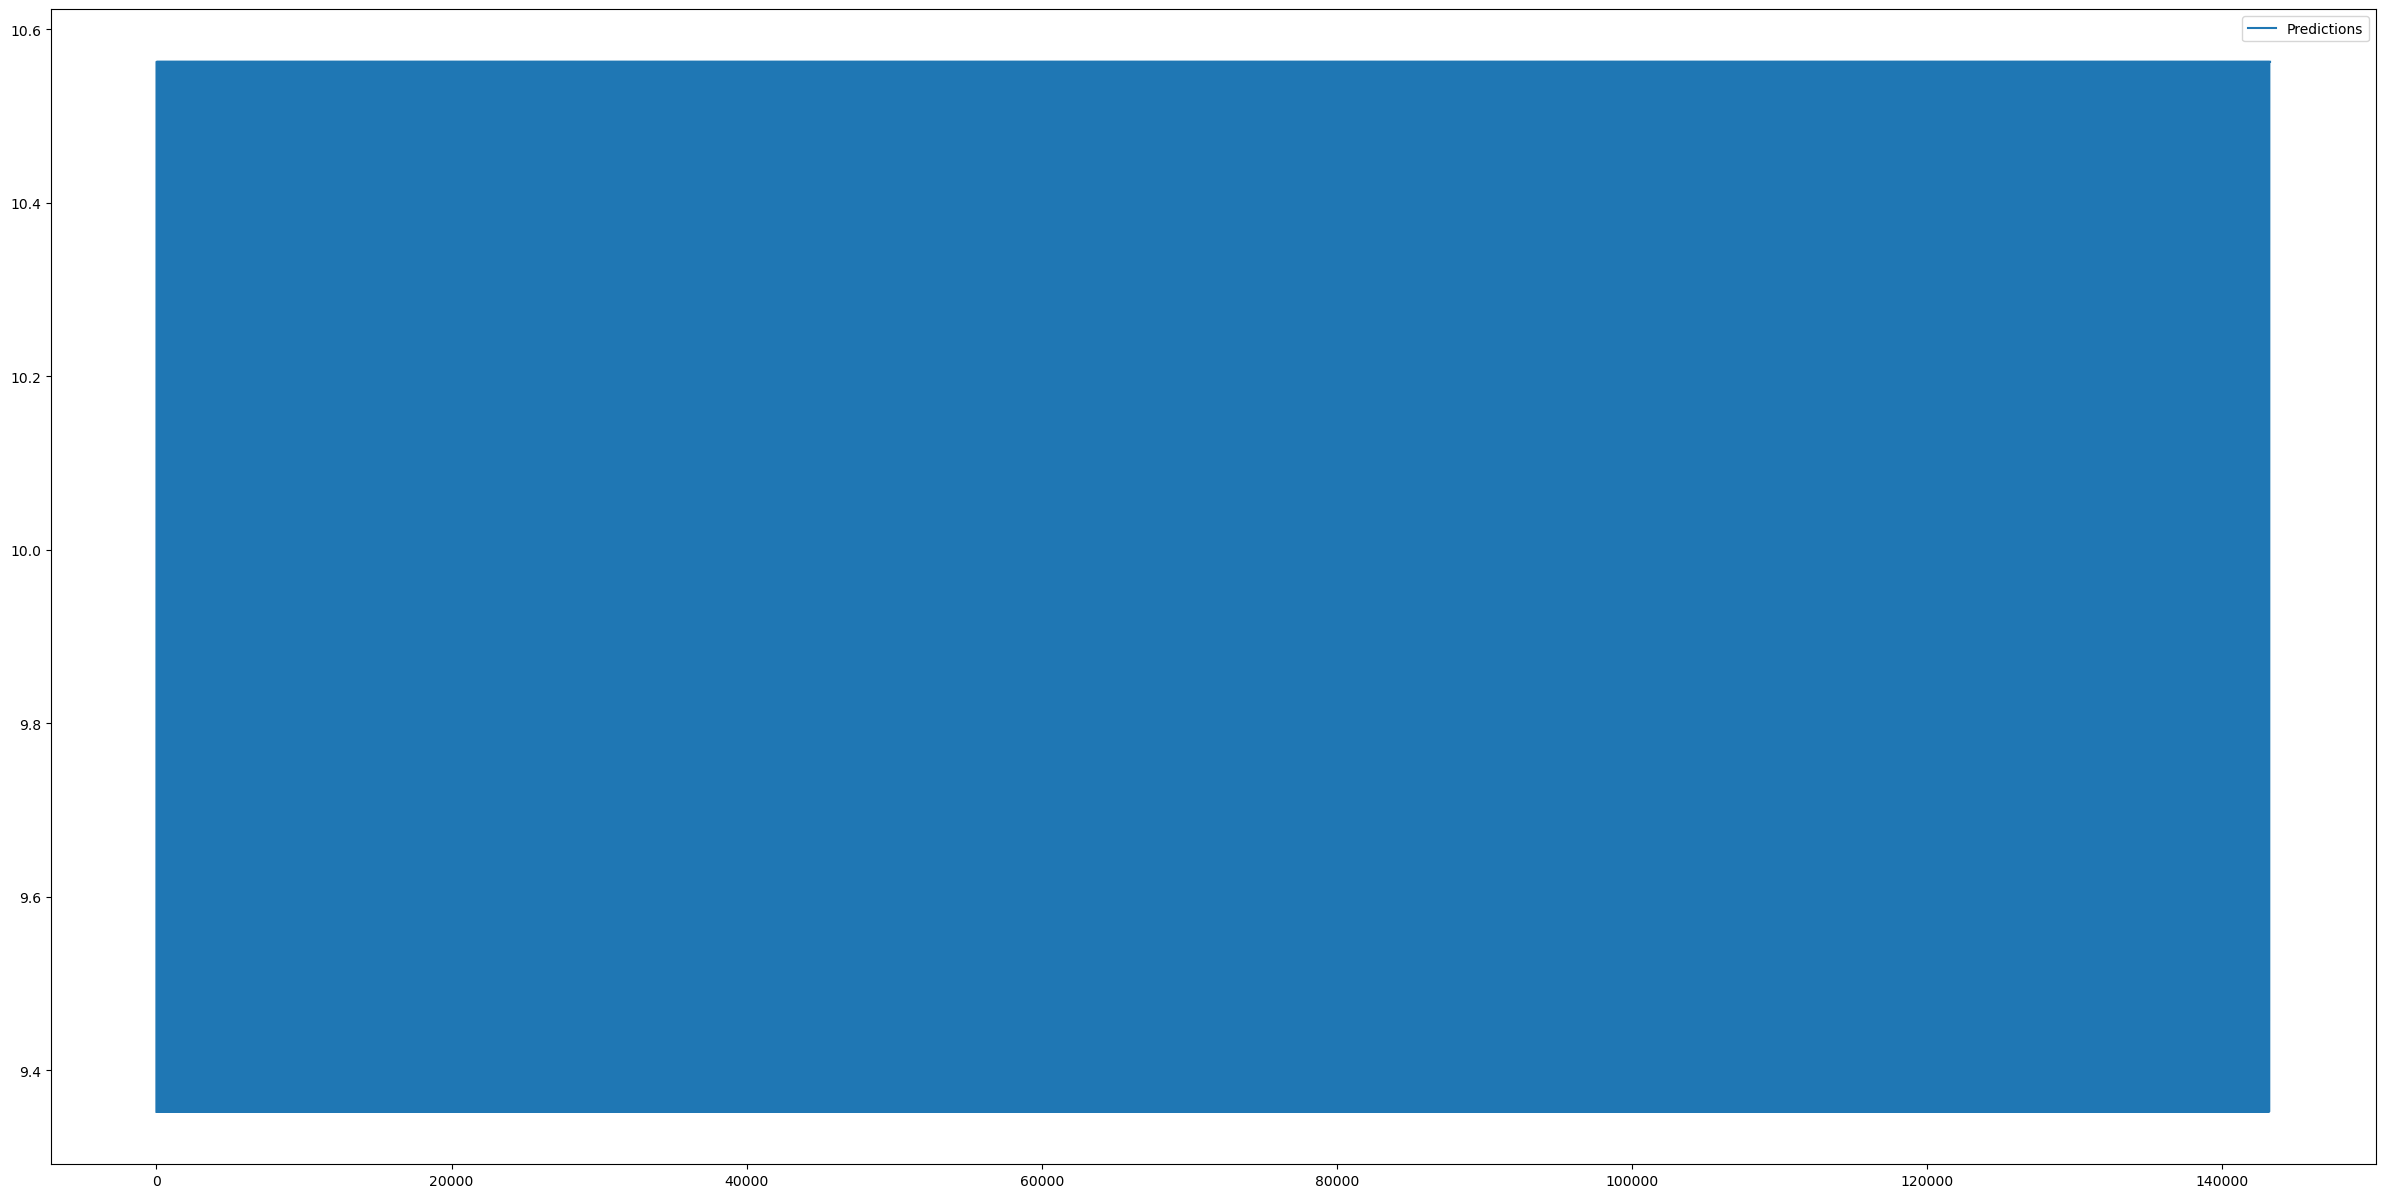

<keras.engine.functional.Functional object at 0x000001943B499BE0> {'train': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'val': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'test': <SkipDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>}
[[[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]

 [[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]

 [[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]

 ...

 [[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]

 [[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]

 [[3.158268 ]
  [3.6308582]
  [3.7032928]
  ...
  [3.7148378]
  [3.7148378]
  [3.7148378]]]


array([3.158268 , 3.6308582, 3.7032928, ..., 3.7148378, 3.7148378,
       3.7148378], dtype=float32)

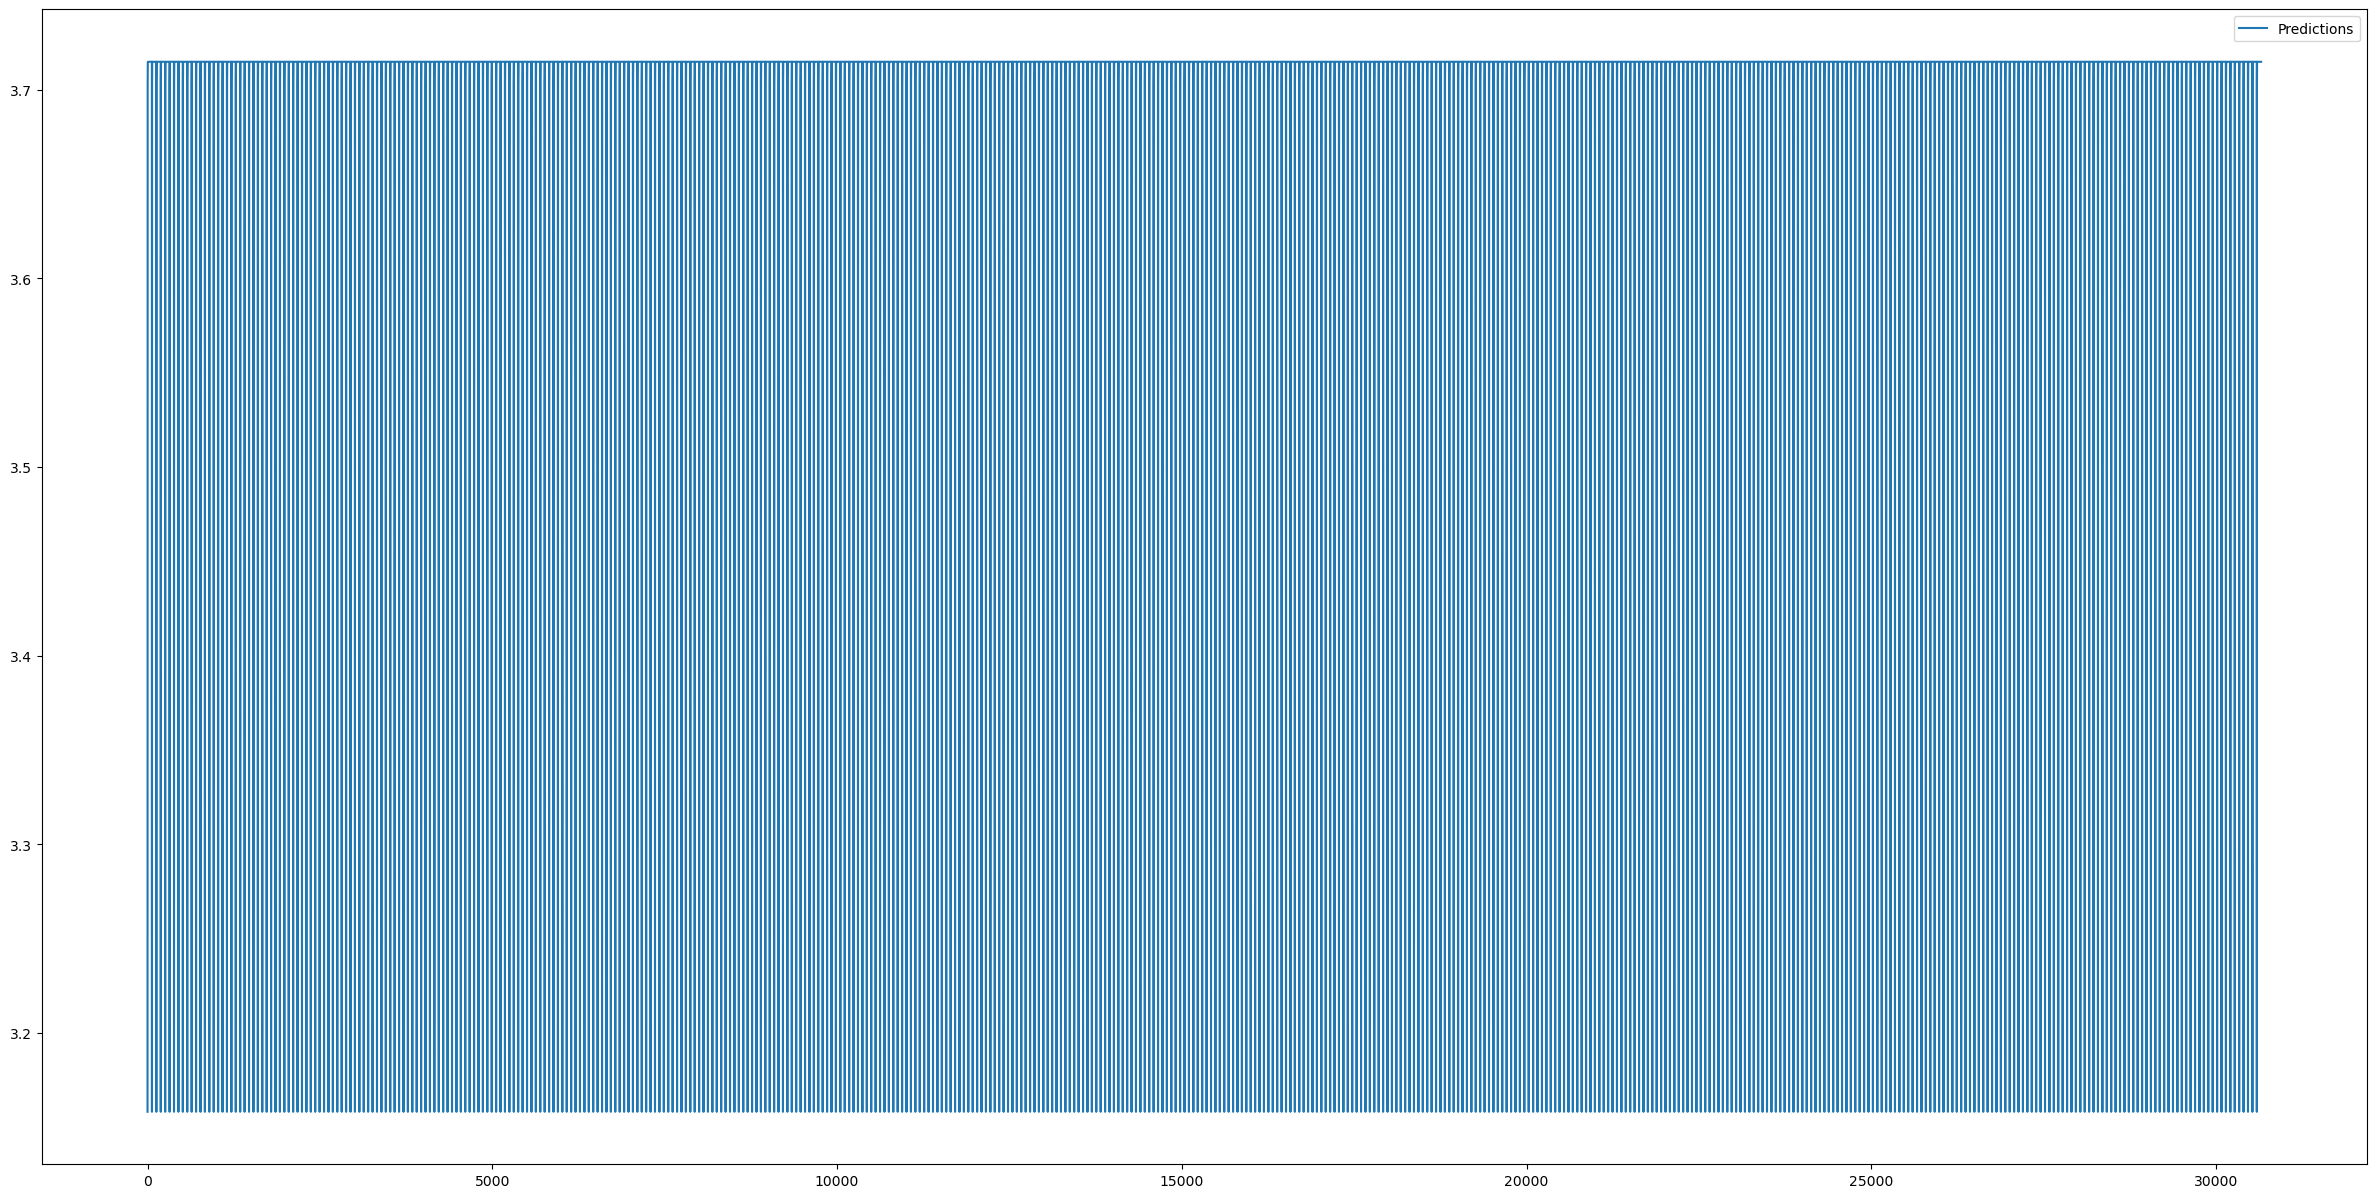

<keras.engine.functional.Functional object at 0x000001943F922F40> {'train': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'val': <TakeDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>, 'test': <SkipDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>}
[[[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]

 [[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]

 [[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]

 ...

 [[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]

 [[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]

 [[2.940596 ]
  [3.49504  ]
  [3.58002  ]
  ...
  [3.5935645]
  [3.5935645]
  [3.5935645]]]


array([2.940596 , 3.49504  , 3.58002  , ..., 3.5935645, 3.5935645,
       3.5935645], dtype=float32)

KeyboardInterrupt: 

In [86]:
for model, dataset in zip(models, datasets.values()):
    print(model, dataset)
    print(model.predict(dataset["test"].take(1)))
    #truth = np.concatenate([y for x, y in dataset["test"]], axis=0)
    #display(truth.shape)
    predictions = model.predict(dataset["test"]).flatten()
    display(predictions)
    #plt.plot(truth, label="Truth")
    plt.plot(predictions, label="Predictions")
    plt.legend()
    plt.show()

    

array([7.4452996, 7.4452996, 7.4452996, ..., 7.4452996, 7.4452996,
       7.4452996], dtype=float32)

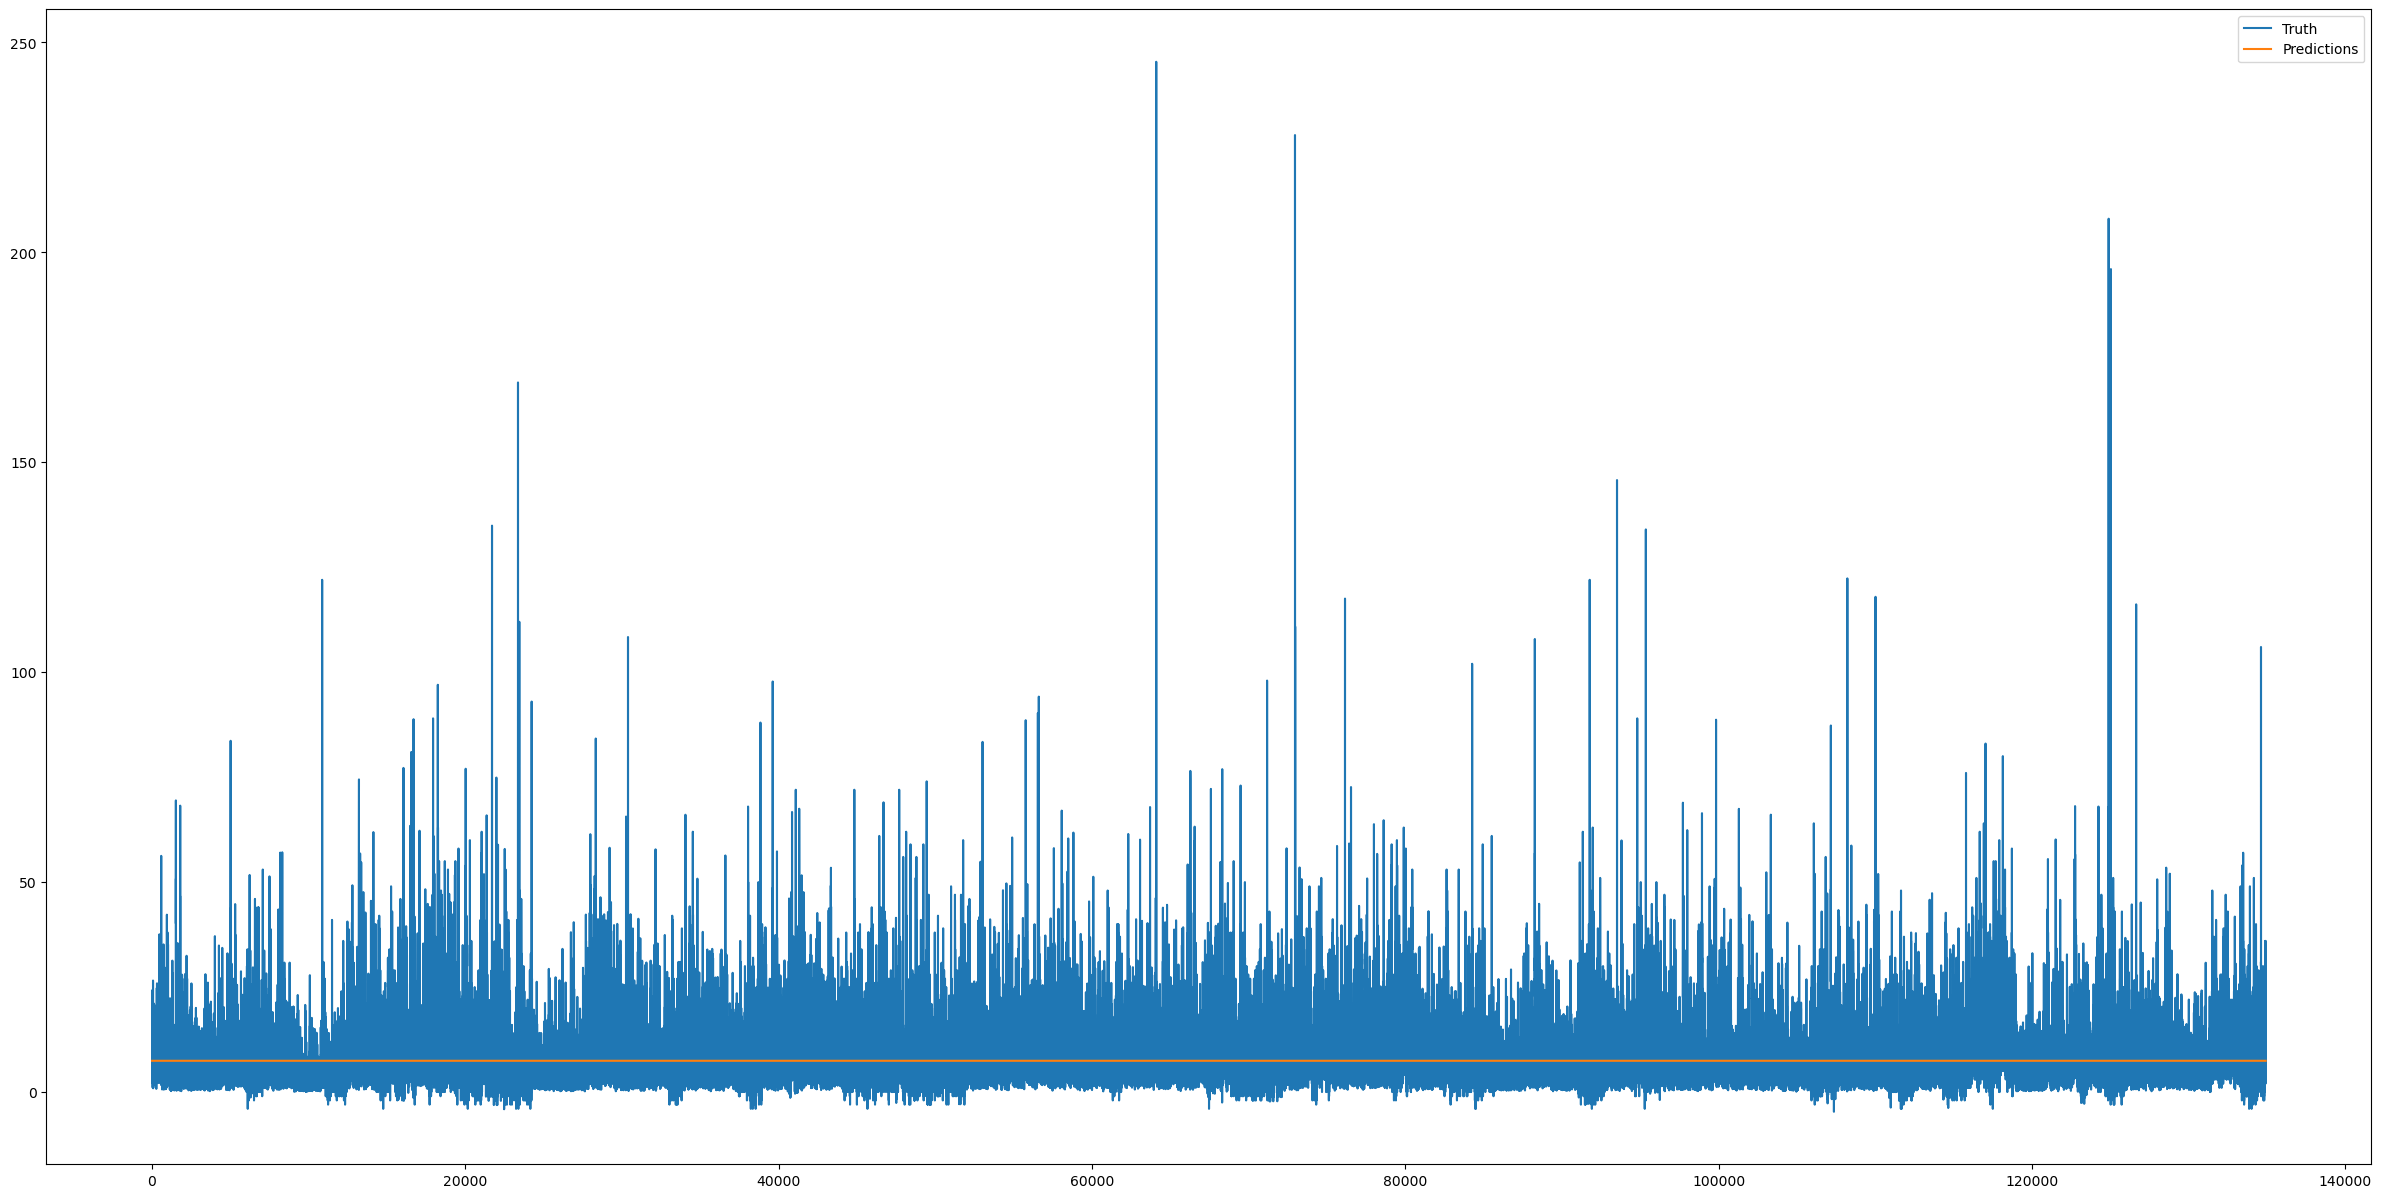

In [ ]:
predictions = model.predict([test_features_split[1], test_features_split[0]]).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [ ]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()

INFO:tensorflow:Assets written to: /content/comp3000model\assets


In [89]:
for model in models:
    tf.saved_model.save(model, "/content/comp3000model/" + model.name + "/")

KeyboardInterrupt: 